<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/Dog-breed-tulam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2900","key":"977eb592f0fe57a4c97e7d050cf9c637"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
!kaggle datasets list

-rw-r--r-- 1 root root 64 Apr 20 02:38 kaggle.json
ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          31262  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          23184  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          22367  
vjchoudhary7/customer-segmentation-tutorial-in-python        Mall Customer Segmentation Data                       2KB  2018-08-11 07:23:02           7491  
bigquer

In [5]:
!kaggle competitions download -c dog-breed-identification
!unzip labels.csv.zip
!unzip train.zip
!unzip test.zip
!unzip sample_submission.csv.zip

  0% 0.00/214k [00:00<?, ?B/s]
100% 214k/214k [00:00<00:00, 68.8MB/s]
  0% 0.00/281k [00:00<?, ?B/s]
100% 281k/281k [00:00<00:00, 92.3MB/s]
 97% 337M/346M [00:04<00:00, 66.1MB/s]
100% 346M/346M [00:04<00:00, 86.8MB/s]
 93% 321M/345M [00:03<00:00, 76.9MB/s]
100% 345M/345M [00:03<00:00, 114MB/s] 
Archive:  labels.csv.zip
  inflating: labels.csv              
Archive:  train.zip
   creating: train/
  inflating: train/000bec180eb18c7604dcecc8fe0dba07.jpg  
  inflating: train/001513dfcb2ffafc82cccf4d8bbaba97.jpg  
  inflating: train/001cdf01b096e06d78e9e5112d419397.jpg  
  inflating: train/00214f311d5d2247d5dfe4fe24b2303d.jpg  
  inflating: train/0021f9ceb3235effd7fcde7f7538ed62.jpg  
  inflating: train/002211c81b498ef88e1b40b9abf84e1d.jpg  
  inflating: train/00290d3e1fdd27226ba27a8ce248ce85.jpg  
  inflating: train/002a283a315af96eaea0e28e7163b21b.jpg  
  inflating: train/003df8b8a8b05244b1d920bb6cf451f9.jpg  
  inflating: train/0042188c895a2f14ef64a918ed9c7b64.jpg  
  inflating: train/00

# 1. Import Thư Viện

In [0]:
import os
import csv
import tempfile
from os import listdir
from io import StringIO
from pathlib import Path
from itertools import islice
from os.path import join, abspath
from collections import namedtuple

import cv2
import pickle
import h5py
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import log_loss
from sklearn.externals import joblib
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import VarianceThreshold

from keras import preprocessing
labels = pd.read_csv('labels.csv')
df_train = os.path.join('train')
df_test = os.path.join('test')
sample = pd.read_csv('sample_submission.csv')

NUM_CLASSES = 16

In [66]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels.shape

(1777, 3)

In [69]:
group = labels.groupby(by='breed', as_index=False).agg({'id': pd.Series.nunique})

group = group.sort_values('id',ascending=False)

labels['rank'] = group['breed']
labels['rank']

8        japanese_spaniel
9                leonberg
12                samoyed
29                    NaN
48                    NaN
57                    NaN
70                    NaN
79                    NaN
80                    NaN
88                    NaN
90                    NaN
102                   NaN
105                   NaN
111                   NaN
115                   NaN
118                   NaN
122                   NaN
141                   NaN
144                   NaN
146                   NaN
149                   NaN
157                   NaN
161                   NaN
164                   NaN
165                   NaN
174                   NaN
201                   NaN
217                   NaN
219                   NaN
223                   NaN
               ...       
9992                  NaN
9993                  NaN
9999                  NaN
10001                 NaN
10020                 NaN
10024                 NaN
10025                 NaN
10031       

In [48]:
selected_breed_list

['id']

# 2. Load File và Đọc File

In [0]:
def load_file(fileNames):
  return [join(fileNames,fileName) for fileName in listdir(fileNames)]

In [0]:
train_path = load_file(df_train)
test_path = load_file(df_test)

In [21]:
NUM_CLASS = 16


ValueError: ignored

In [10]:
print(len(train_path),len(test_path))

10222 10357


# 3. Chuyển Hình Ảnh thành Ma trận

In [0]:
def rescale(img):
  return cv2.resize(img,(224,224),interpolation = cv2.INTER_AREA)
train = [rescale(plt.imread(train_path)) for train_path in train_path]
test = [rescale(plt.imread(test_path)) for test_path in test_path]


In [0]:
train = np.array(X_train)
test = np.array(X_test)

In [0]:
X_train,y_train ,X_val,y_val = train_test_split(traintest_size = 0.2, random_state 2)

# Lưu Vào Thành File Và Mở File

In [0]:
def save_data(file, fileName):
  with open(fileName, 'wb') as f:
    pickle.dump(file,f)
  f.close()
def open_data(file):
  with open(file,'rb') as f:
    file = pickle.load(f)
  return file
    

In [0]:
# lưu file data
save_data(X_train,"trainDf")
save_data(X_test,"testDf")

In [0]:
# thông tin data thành ma trận
file_train = open_data("trainDf")
file_test = open_data("testDf")

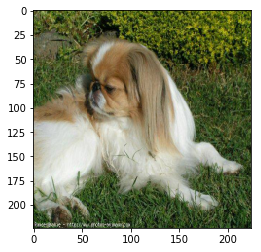

In [16]:
# show bức ảnh đầu tiên
plt.imshow(file_train[0])
plt.imshow(file_test[0])

# 4. Xử lý Label Chuyển Từ String thành Binary

In [0]:
labels = pd.read_csv('labels.csv')
def process_labels(data):
  breed = data['breed']
  files = []
  for file in breed:
    if file not in files:
      files.append(file)
  _labels = [[index, label] for index, label in enumerate(files)]      

In [0]:
breed = labels['breed']
files = []
for file in breed:
  if file not in files:
    files.append(file)


In [0]:
files.sort()

In [0]:
_labels = [[label, index] for index, label in enumerate(files)]
print(len(breed), len(_labels))

10222 120


In [0]:
_labels[0]

['affenpinscher', 0]

In [0]:
for i in range(len(breed)):
  for j in _labels:
    if breed[i] == j[0]:
      breed[i] = j[1]
      break

In [0]:
def _categorical(data):
  _labels = [label for label in data['breed']]
  count = 0
  _labelsAndCount = []
  for item in _labels:
    _labelsAndCount.append([i,count])
    count = count+1
  return count, _labelsAndCount
# _categorical keras chi so sanh gia tri label voi index 
# vi du son >>> so


In [0]:
from keras.utils import to_categorical
breed = to_categorical(breed)

In [0]:
breed.shape

(10222, 120)

In [0]:
y = np.array(breed)
y.shape

(10222, 120)

In [0]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [0]:
# su dung labelencoder va onehotencode su ly data
labels = pd.read_csv('labels.csv')
breed = labels['breed']

def procesdata_in_sklearn(data):
  enc = LabelEncoder()
  numbers = enc.fit_transform(data)
  df = pd.DataFrame(numbers,data)
  enc1 = OneHotEncoder(categories='auto')
  y = enc1.fit_transform(df).toarray()
  return y

In [0]:
y_pred = procesdata_in_sklearn(breed)


In [0]:
y_pred.shape

(10222, 120)

# 6. Xử Lý Ảnh 

In [0]:
index = np.array(list(range(file_train.shape[0])))
np.random.shuffle(index)


In [0]:
Xs = file_train[index]
Ys = y[index]


In [0]:
print('file_train',file_train.shape)
print('y', y.shape)

file_train (10222, 224, 224, 3)
y (10222, 120)


In [0]:
Xs = (file_train-127.5)/255
Xs = Xs.astype('float32')

In [0]:
test = (X_test - 127.5)/255
test = test.astype('float32')


# Visualizing training data distribution

**1. let’s do the data visualization for better understanding the data**

In [0]:
breed_counts = pd.pivot_table(labels, index=['breed'], aggfunc='count')
# rename the column
breed_counts = breed_counts.rename(columns = {"id" : "count"})
# show in desending order 
breed_counts = breed_counts.sort_values("count", ascending=False)
# show top 5 rows
breed_counts.head(5)


,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Distribution of Dog breeds')

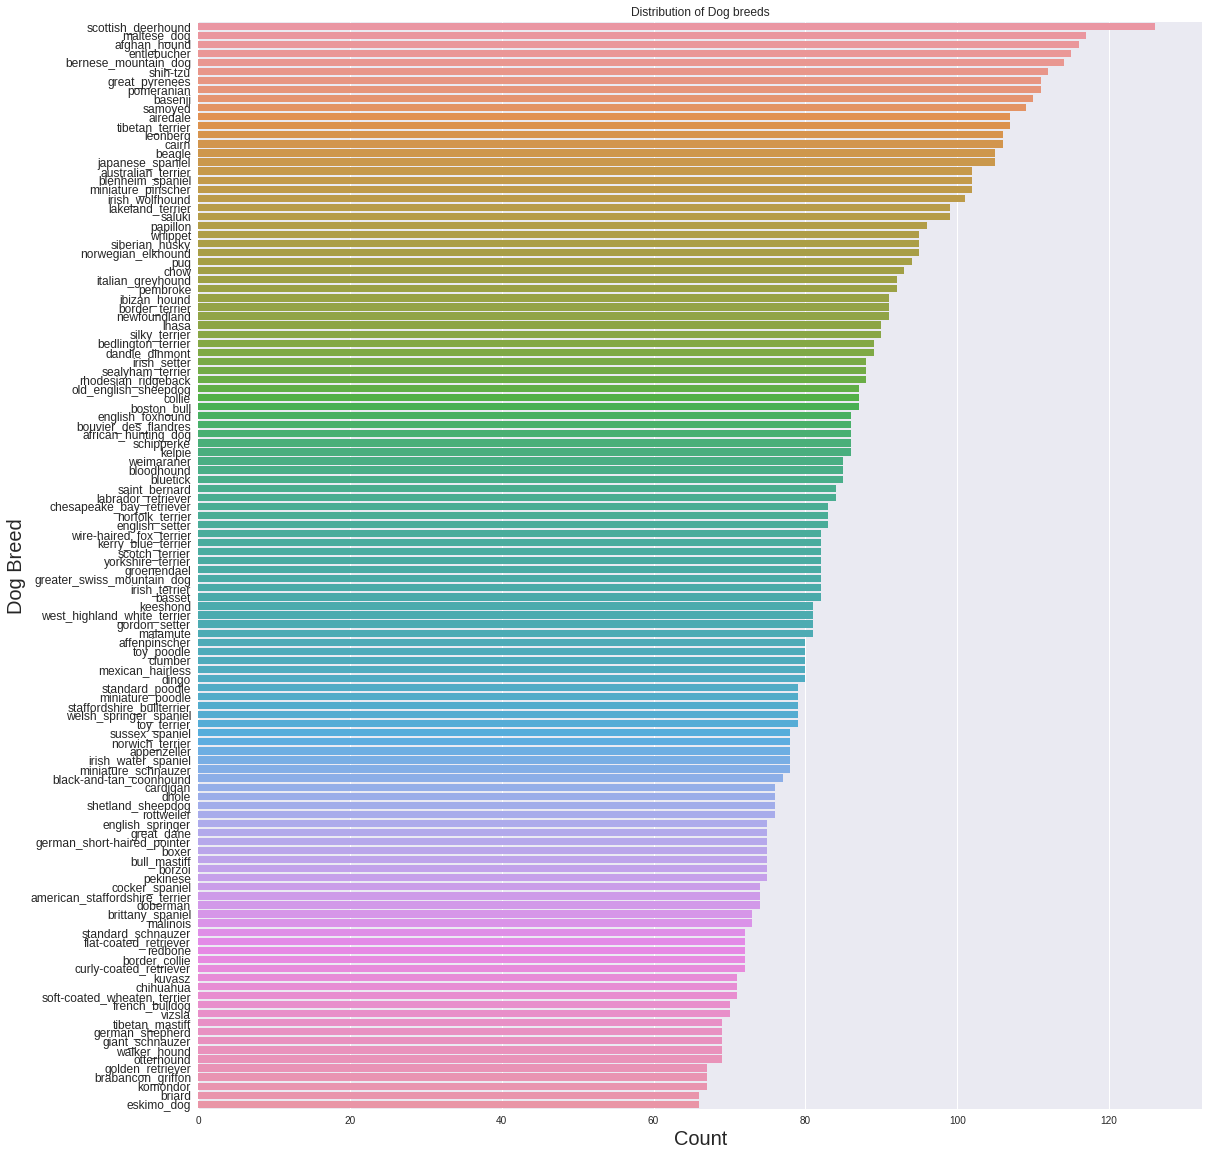

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(18,20)
sns.set_style("whitegrid")

ax = sns.barplot(x = breed_counts['count'], y = breed_counts.index, data = labels)
# vẽ ra biểu đồ cột các giá trị của breed_count
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)
# xác định khoảng cách của x và y
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.set(xlabel='Count',ylabel='Dog Breed')
ax.set_title('Distribution of Dog breeds')

**2.loading the corresponding Images**

#  Xây Dựng Model

In [0]:
import time
import numpy
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
import time
import numpy
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam

In [0]:
def Builde_model():
  """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
  model = Sequential()
  # x(shortcut)
  # X(Shortcut) 
  # xay dung model convolution với 32 dense
  model.add(Conv2D( 32, 3, input_shape=(100,100,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(32,  3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  # xay dung model convolution voi 16
  model.add(Conv2D(16,3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(16,3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  # xay dung model voi 256 dense
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(120))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(120))
  model.add(Activation('softmax'))
  
  model.compile(optimizer = Adam(lr = 0.001),
                loss = 'mse',
                metrics=['mse','accuracy']
               )
  return model


In [0]:
model = Builde_model()
t0=time.time()
log3 = model.fit(Xs, Ys, validation_split=0.2, epochs=50, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

#scores3 = model.evaluate(X_test, y_test, verbose=0)
#print("CNN Error: %.2f%%" % (100-scores3[1]*100))
 
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.plot(log3.history['acc'],'b') 
plt.plot(log3.history['val_acc'],'r')
plt.show()

# INCEPTION MODEL

In [0]:
def inception2BN(input_, n = 32):
  p1 = Conv2D(n, 1, padding='same')(input_)
  p1 = BatchNormalization()(p1)
  p1 = Activation('relu')(p1)
  
  p2 = Conv2D(n, 1, padding='same')(input_)
  p2 = BatchNormalization()(p2)
  p2 = Activation('relu')(p2)
  p2 = Conv2D(n, 3, padding='same')(p2)
  p2 = BatchNormalization()(p2)
  p2 = Activation('relu')(p2)
  
  p3 = Conv2D(n, 1, padding='same')(input_)
  p3 = BatchNormalization()(p3)
  p3 = Activation('relu')(p3) 
  p3 = Conv2D(n, 5, padding='same')(p3)
  p3 = BatchNormalization()(p3)
  p3 = Activation('relu')(p3)
  
  p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(input_) 
  p4 = Conv2D(n, 1, padding='same')(p4)
  p4 = BatchNormalization()(p4)
  p4 = Activation('relu')(p4)
  
  c = Concatenate(axis=-1)([p1,p2,p3,p4])
  return c

def model3():
  inputs = Input(shape=(100, 100, 3))
  
  i1 = inception2BN(inputs)
  mp1 = MaxPooling2D((2,2))(i1)
  
  f = Flatten()(mp1)
  d = Dense(128)(f)
  d = BatchNormalization()(d)
  d = Activation('relu')(d)
  out = Dense(120, activation='softmax')(d)
  model = Model(inputs, out)
  return model

model3 = model3()
adam = Adam(lr=0.001)
model3.compile(loss= 'categorical_crossentropy', optimizer=adam, metrics=[ 'accuracy' ])

log3 = model3.fit(Xs, y, validation_split=0.2, epochs=15, batch_size=32)

 

# scores3 = model3.evaluate(X_test, y_test, verbose=0)
# print("CNN Error: %.2f%%" % (100-scores3[1]*100))
  

Train on 8177 samples, validate on 2045 samples
Epoch 1/15
8177/8177 [==============================] - 31s 4ms/step - loss: 4.6908 - acc: 0.0282 - val_loss: 4.5385 - val_acc: 0.0416
Epoch 2/15
8177/8177 [==============================] - 26s 3ms/step - loss: 4.2201 - acc: 0.0709 - val_loss: 4.3606 - val_acc: 0.0582
Epoch 3/15
8177/8177 [==============================] - 26s 3ms/step - loss: 3.8046 - acc: 0.1540 - val_loss: 4.3717 - val_acc: 0.0636
Epoch 4/15
8177/8177 [==============================] - 26s 3ms/step - loss: 3.1617 - acc: 0.3033 - val_loss: 4.4406 - val_acc: 0.0645
Epoch 5/15
8177/8177 [==============================] - 26s 3ms/step - loss: 1.8455 - acc: 0.6661 - val_loss: 4.9007 - val_acc: 0.0582
Epoch 6/15
8177/8177 [==============================] - 26s 3ms/step - loss: 0.4588 - acc: 0.9606 - val_loss: 5.1155 - val_acc: 0.0430
Epoch 7/15
8177/8177 [==============================] - 26s 3ms/step - loss: 0.0724 - acc: 0.9983 - val_loss: 4.9343 - val_acc: 0.0548
Epoch 8

In [0]:
pred = model3.predict(X_test)

In [0]:
eva = model3.evaluate(X_test,pred)

10357/10357 [==============================] - 15s 1ms/step


In [0]:
array = []
for i in range(len(pred)):
  for j in range(0,120):
    if(pred[i][j]> 0.99):
      print('thu tu cua i,j', i,j)
      array.append(pred[i][j])

In [0]:
X_test[0].shape

(227, 227, 3)

# Alex Net


In [0]:
def alexNet():
  model = Sequential()
  # layer 1 
  model.add(Conv2D(filters=96, input_shape = (224,224,3),kernel_size=(11,11), strides=(4,4), padding = 'valid'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
  model.add(Activation('relu'))
  # layer 2 
  model.add(Conv2D(filters= 256, kernel_size=(5,5), strides=(1,1), padding = 'valid'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),padding='valid'))
  
  # layer 3 
  model.add(Conv2D(filters= 384, kernel_size=(3,3), strides=(1,1), padding = 'valid'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  # layer 4
  model.add(Conv2D(filters= 384, kernel_size=(3,3), strides=(1,1), padding = 'valid'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  # layer 5
  model.add(Conv2D(filters= 256, kernel_size=(3,3), strides=(1,1), padding = 'valid'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
  
  # pass combine fully connected layer
  model.add(Flatten())
  # FC 1 
  model.add(Dense(4096, input_shape= (224*224*3,)))
  model.add(Activation('relu'))
  model.add(Dropout(0.4))
  # FC2
  model.add(Dense(4096)) 
  model.add(Activation('relu'))
  model.add(Dropout(0.4))
  # FC3 
  model.add(Dense(1000))
  model.add(Activation('relu'))
  model.add(Dropout(0.4))
  
  # output layer 
  model.add(Dense(120))
  model.add(Activation('softmax'))
  return model

In [0]:
model = alexNet()
adam = Adam(lr=0.001)
model.compile(loss= 'categorical_crossentropy', 
              optimizer=adam,
              metrics=[ 'accuracy' ])

In [0]:
fit_ =  model.fit(file_train, y, validation_split=0.2, verbose=2, epochs=50, batch_size=128,shuffle=True)

Train on 8177 samples, validate on 2045 samples
Epoch 1/50
 - 21s - loss: 3.4870 - acc: 0.1239 - val_loss: 4.3153 - val_acc: 0.0738
Epoch 2/50
 - 18s - loss: 3.3282 - acc: 0.1514 - val_loss: 4.4417 - val_acc: 0.0802
Epoch 3/50
 - 18s - loss: 3.1757 - acc: 0.1712 - val_loss: 4.3280 - val_acc: 0.0851
Epoch 4/50
 - 18s - loss: 3.0707 - acc: 0.1833 - val_loss: 4.3520 - val_acc: 0.0856
Epoch 5/50
 - 18s - loss: 2.9869 - acc: 0.2033 - val_loss: 4.7456 - val_acc: 0.0748
Epoch 6/50
 - 18s - loss: 2.8757 - acc: 0.2168 - val_loss: 4.7893 - val_acc: 0.0753
Epoch 7/50
 - 18s - loss: 2.7329 - acc: 0.2428 - val_loss: 4.4946 - val_acc: 0.0890
Epoch 8/50
 - 18s - loss: 2.6330 - acc: 0.2673 - val_loss: 4.9379 - val_acc: 0.0870
Epoch 9/50
 - 18s - loss: 2.4860 - acc: 0.2942 - val_loss: 4.8568 - val_acc: 0.0905
Epoch 10/50
 - 18s - loss: 2.3776 - acc: 0.3095 - val_loss: 5.0603 - val_acc: 0.0919
Epoch 11/50
 - 18s - loss: 2.2175 - acc: 0.3500 - val_loss: 5.1303 - val_acc: 0.0905
Epoch 12/50
 - 18s - loss:

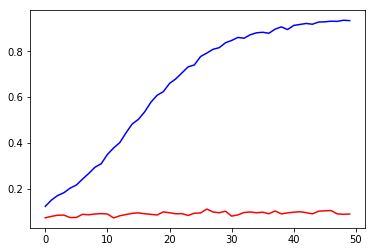

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.plot(fit_.history['acc'],'b') 
plt.plot(fit_.history['val_acc'],'r')
plt.show()

In [0]:
adam = Adam(lr=0.001)
model.compile(loss= 'categorical_crossentropy', optimizer=adam, metrics=[ 'accuracy' ])
t0=time.time()
log3 = model.fit(X_train, y, validation_split=0.2,verbose=2,epochs=15, batch_size=16)
t1=time.time()
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.plot(log3.history['acc'],'b') 
plt.plot(log3.history['val_acc'],'r')
plt.show()

# LE NET -5 

In [0]:
def leNet():
  model = Sequential()
  #layer 1 conv2
  model.add(Conv2D(filters=6,input_shape= (32,32,3), kernel_size=(3,3) , strides=1))
  model.add(Activation('relu'))
  # layer 2 avgpooling
  model.add(AveragePooling2D(pool_size=(2,2),strides=2))
  model.add(BatchNormalization())
  # layer 3 conv2d
  model.add(Conv2D(filters=16, kernel_size=(3,3),strides=2))
  model.add(AveragePooling2D(pool_size=(2,2),strides=2))
  # layer 4 avgpooling
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(Flatten())
  
  model.add(Dense(120))
  model.add(Activation('relu'))
  model.add(Dropout(0.4))
  
  model.add(Dense(84))
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(120))
  model.add(Activation('softmax'))
  
  return model

In [0]:
model = leNet()

adam = Adam(lr=0.001)
model.compile(loss= 'categorical_crossentropy', optimizer=adam, metrics=[ 'accuracy' ])
t0=time.time()
log3 = model.fit(file_train, y, validation_split=0.2,verbose=2,epochs=30, batch_size=64, shuffle=True)
t1=time.time()

import matplotlib.pyplot as plt
%matplotlib inline
 
plt.plot(log3.history['acc'],'b') 
plt.plot(log3.history['val_acc'],'r')
plt.show()

# VGG NET

In [0]:
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100,100,3))

In [0]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [0]:
adam = Adam(lr = 0.001)

In [0]:
model = Sequential()
for layer in vgg16_model.layers:
  model.add(layer)
model.layers.pop()
for layer in model.layers:
  layer.trainable = False

# Flatten model
model.add(Flatten())

# Add dense layer
model.add(Dense(120, activation = 'softmax'))

In [0]:
model.compile(loss= 'categorical_crossentropy' , optimizer= Adam(lr= 0.001) , metrics=[ 'accuracy' ])
model.fit(Xs, y, validation_split=0.2, epochs=50, batch_size=256, verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 8177 samples, validate on 2045 samples
Epoch 1/50
 - 21s - loss: 4.6259 - acc: 0.0489 - val_loss: 4.2341 - val_acc: 0.0905
Epoch 2/50
 - 12s - loss: 3.4966 - acc: 0.2375 - val_loss: 3.9504 - val_acc: 0.1399
Epoch 3/50
 - 11s - loss: 2.9066 - acc: 0.3699 - val_loss: 3.8120 - val_acc: 0.1575
Epoch 4/50
 - 11s - loss: 2.4793 - acc: 0.4779 - val_loss: 3.7776 - val_acc: 0.1711
Epoch 5/50
 - 11s - loss: 2.1470 - acc: 0.5652 - val_loss: 3.7457 - val_acc: 0.1594
Epoch 6/50
 - 11s - loss: 1.8607 - acc: 0.6537 - val_loss: 3.7033 - val_acc: 0.1765
Epoch 7/50
 - 11s - loss: 1.6262 - acc: 0.7207 - val_loss: 3.7130 - val_acc: 0.1711
Epoch 8/50
 - 11s - loss: 1.4317 - acc: 0.7769 - val_loss: 3.7050 - val_acc: 0.1790
Epoch 9/50
 - 11s - loss: 1.2598 - acc: 0.8226 - val_loss: 3.7051 - val_acc: 0.1824
Epoch 10/50
 - 11s - loss: 1.1170 - acc: 0.8525 - val_loss: 3.7181 - val_acc: 0.1800
Epoch 11/50
 - 11s - loss: 0.9842 - acc: 0.8886 - val_loss: 3.7761 - val_acc: 0.1868
Epoch 12/50
 - 11s - loss:

In [0]:
def VGGnet_16():
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), input_shape=(224,224,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000))
    model.add(Dense(120, activation='softmax'))
    return model

In [0]:
model = VGGnet_16()
model.compile(loss= 'categorical_crossentropy' ,
              optimizer= Adam(lr= 0.001) , 
              metrics=[ 'accuracy' ])

In [0]:
model.fit(Xs, y, 
          validation_split=0.2, 
          epochs=50, 
          batch_size=256, 
          verbose=2)

Train on 8177 samples, validate on 2045 samples
Epoch 1/50


# INCEPTION NETWORK LAYER 28X2X192

In [0]:
def inception(inputs):
  
  p1 = Conv2d(64, (1,1))(inputs)
  p1 = BatchNormalization()
  p1 = Activation('relu')
  
  p2 = Conv2d(96, (1,1))(inputs)
  p2 = BatchNormalization()(p2)
  p2 = Activation('relu')(p2)
  p2 = Conv2d(128, (3,3))(p2)
  p2 = BatchNormalization()(p2)
  p2 = Activation('relu')(p2)
  
  p3 = Conv2d(16, (1,1), padding= 'same')(inputs)
  p3 = BatchNormalization()(p3)
  p3 = Activation('relu')(p3)
  p3 = Conv2d(32, (5,5), padding='same')(p3)
  p3 = BatchNormalization()(p3)
  p3 = Activation('relu')(p3)
  
  p4 = MaxPooling((3,3),padding = 'same', strides= (1,1))(inputs)
  p4 = Conv2d(32, (1,1),padding = 'same')(p4)
  p4 = BatchNormalization()(p4)
  p4 = Activation('relu')(p4)
  
  c = Concatenate(axis=-1)([p1,p2,p3,p4])
  return c
